In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# ---------------------------------------
# 1. Load and Prepare Data
# ---------------------------------------

def load_and_prepare_data():
    macro = pd.read_csv("macro_data.csv", parse_dates=["DATE"]).set_index("DATE")
    forex = pd.read_csv("forex_merged_cleaned.csv", parse_dates=["DATE"]).set_index("DATE")
    
    log_returns = np.log(forex / forex.shift(1)).dropna()
    log_returns.columns = [col + " Return" for col in log_returns.columns]

    LAG_PERIODS = (1, 2, 3, 4, 5, 12, 24, 60)
    ROLL_WINDOWS = (3, 5, 7, 10)

    def enrich_macro_safe(df):
        fea = df.copy()
        for p in LAG_PERIODS:
            fea = pd.concat([fea, df.shift(p).add_suffix(f"_lag{p}")], axis=1)
        for w in ROLL_WINDOWS:
            fea = pd.concat([
                fea,
                df.rolling(w).mean().shift(1).add_suffix(f"_rollmean{w}"),
                df.rolling(w).std().shift(1).add_suffix(f"_rollstd{w}")
            ], axis=1)
        return fea.dropna()

    macro_fea = enrich_macro_safe(macro)
    
    full_df = pd.merge(macro_fea, log_returns, left_index=True, right_index=True).dropna()
    return full_df, forex

# ---------------------------------------
# 2. Train Model Helper
# ---------------------------------------

def train_model(X_train, y_train, selected_model):
    if selected_model == 'Lasso':
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        model = Lasso(alpha=0.01, max_iter=10000)
        model.fit(X_train_scaled, y_train)
        
        return model, scaler
    elif selected_model == 'XGBoost':
        model = XGBRegressor(n_estimators=500, learning_rate=0.05)
        model.fit(X_train, y_train)
        
        return model, None
    elif selected_model == 'OLS':
        X_train_const = sm.add_constant(X_train, has_constant='add')
        model = sm.OLS(y_train, X_train_const).fit()
        return model, None
    elif selected_model == 'LassoCV':
        transformer = Pipeline([('scaler', StandardScaler()),
                                 ('pca', PCA(n_components = 0.95)) # min components needed to explain 95% of the variance in data
                               ])
        X_reduced = transformer.fit_transform(X_train)
        model = LassoCV(cv = TimeSeriesSplit(n_splits = 5),
                        max_iter = 10000,
                        tol = 1e-3,
                       )
        model.fit(X_reduced, y_train)
            
        return model, transformer

    else:
        raise ValueError(f"Model {selected_model} not supported.")

# ---------------------------------------
# 3. Main Full Function
# ---------------------------------------

def run_forex_model(selected_macros, selected_model, macro_adjustments=None, future_years=10):
    """
    selected_macros: list of macro factors like ['Interest Rate', 'Inflation']
    selected_model: 'Lasso', 'LassoCV', 'XGBoost', or 'OLS'
    macro_adjustments: dictionary like {'Interest Rate': 0.5} (optional)
    future_years: number of years to predict forward (5, 7, 10)
    """

    full_df, forex = load_and_prepare_data()
    
    fx_targets = [col for col in full_df.columns if "Return" in col]
    available_macros = [col for col in full_df.columns if any(macro in col for macro in selected_macros)]

    train_end = "2022-12-31"
    train_df = full_df[full_df.index <= train_end]
    test_df = full_df[full_df.index > train_end]

    all_results = []
    all_future_preds = []

    for target in fx_targets:
        y_train = train_df[target]
        y_test = test_df[target]
        X_train = train_df[available_macros]
        X_test = test_df[available_macros]
        
        model, scaler = train_model(X_train, y_train, selected_model)

        # --- Predict on real 2023–2025 test set ---
        if selected_model == 'OLS':
            X_test_const = sm.add_constant(X_test, has_constant='add')
            preds = model.predict(X_test_const)
        else:
            if scaler:
                preds = model.predict(scaler.transform(X_test))
            else:
                preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        all_results.append({
            "Currency": target.replace(" Return", ""),
            "Model": selected_model,
            "Selected_Macros": selected_macros,
            "R2_Score": r2,
            "MAE": mae,
            "RMSE": rmse,
        })

        # --- Predict Future based on macro adjustment ---
        last_known_macros = train_df[available_macros].iloc[-1]

        months = future_years * 12
        future_macro_df = pd.DataFrame([last_known_macros.values] * months, columns=available_macros)

        if macro_adjustments:
            for macro, adjustment in macro_adjustments.items():
                matching_cols = [col for col in available_macros if macro in col]
                for col in matching_cols:
                    future_macro_df[col] += adjustment
        
        # Predict future
        if selected_model == 'OLS':
            future_macro_const = sm.add_constant(future_macro_df, has_constant='add')
            future_preds = model.predict(future_macro_const)
        else:
            if scaler:
                future_macro_scaled = scaler.transform(future_macro_df)
                future_preds = model.predict(future_macro_scaled)
            else:
                future_preds = model.predict(future_macro_df)
        
        # Build predicted forex prices
        forex_pair = target.replace(" Return", "")
        last_real_price = forex[forex_pair].iloc[-1]
        future_price_series = last_real_price * np.exp(pd.Series(future_preds)).cumprod()
        
        future_dates = pd.date_range(start="2025-01-01", periods=months, freq='MS')
        temp_future_df = pd.DataFrame({
            'DATE': future_dates,
            'Currency': forex_pair,
            'Predicted_Return': future_preds,
            'Predicted_Forex_Rate': future_price_series.values
        })
        
        all_future_preds.append(temp_future_df)

    results_df = pd.DataFrame(all_results)
    future_preds_df = pd.concat(all_future_preds)

    return results_df, future_preds_df


In [5]:
# test call
real_metrics, future_predictions = run_forex_model(
    selected_macros=['Interest Rate', 'Inflation'],   
    selected_model='LassoCV',                              
    macro_adjustments={'Interest Rate': 0.5},          
    future_years=7                                     
)

# See outputs
print(real_metrics.head())          # Should show R², MAE, RMSE for real 2023–2025 test data
print(future_predictions.head())    # Should show predicted returns and forex rates into future


  Currency    Model             Selected_Macros  R2_Score       MAE      RMSE
0  USD-AUD  LassoCV  [Interest Rate, Inflation] -0.009747  0.021536  0.026352
1  USD-CAD  LassoCV  [Interest Rate, Inflation] -0.021359  0.013683  0.016418
2  USD-CHF  LassoCV  [Interest Rate, Inflation] -0.004782  0.021248  0.023524
3  USD-CNY  LassoCV  [Interest Rate, Inflation] -0.020634  0.011622  0.014877
4  USD-EUR  LassoCV  [Interest Rate, Inflation] -0.003284  0.016560  0.018896
        DATE Currency  Predicted_Return  Predicted_Forex_Rate
0 2025-01-01  USD-AUD          0.000784              1.569366
1 2025-02-01  USD-AUD          0.000784              1.570597
2 2025-03-01  USD-AUD          0.000784              1.571830
3 2025-04-01  USD-AUD          0.000784              1.573063
4 2025-05-01  USD-AUD          0.000784              1.574297


In [31]:
import statsmodels.api as sm
import pandas as pd

# Load preprocessed data
full_df, _ = load_and_prepare_data()

# Define all 10 base macro features (not lags or rolls)
base_macros = [
    "Interest Rate", "Inflation (CPI)", "Core Inflation", "Industrial Production",
    "Retail Sales", "Consumer Sentiment", "Unemployment Rate",
    "Manufacturing PMI", "S&P 500 Index", "VIX Index"
]

# Filter features that actually exist in the data
available_macros = [col for col in full_df.columns if col in base_macros]

# Define currency targets
fx_targets = [col for col in full_df.columns if "Return" in col]

# Train/test split
train_end = "2022-12-31"
train_df = full_df[full_df.index <= train_end]

# Collect OLS results
results = []

for target in fx_targets:
    y = train_df[target]
    X = train_df[available_macros]
    X_const = sm.add_constant(X)
    
    model = sm.OLS(y, X_const).fit()
    coeffs = model.params
    pvals = model.pvalues

    for feature in coeffs.index:
        if feature != "const":
            results.append({
                "Currency": target.replace(" Return", ""),
                "Feature": feature,
                "Coefficient": coeffs[feature],
                "P_Value": pvals[feature],
                "Significant": "Yes" if pvals[feature] < 0.05 else "No"
            })

# Create clean summary table
ols_summary = pd.DataFrame(results)
display(ols_summary.sort_values(["Currency", "Feature"]))

,Currency,Feature,Coefficient,P_Value,Significant
5,USD-AUD,Consumer Sentiment,2.133498e-03,0.000066,Yes
1,USD-AUD,Core Inflation,-7.040325e-03,0.000572,Yes
3,USD-AUD,Industrial Production,6.106498e-04,0.677891,No
0,USD-AUD,Inflation (CPI),7.423208e-03,0.000280,Yes
2,USD-AUD,Interest Rate,-4.156450e-03,0.091630,No
...,...,...,...,...,...
97,USD-XAU,Manufacturing PMI,-1.208349e-04,0.905261,No
94,USD-XAU,Retail Sales,2.249356e-07,0.527141,No
98,USD-XAU,S&P 500 Index,-4.647655e-06,0.816554,No
96,USD-XAU,Unemployment Rate,-3.176298e-03,0.430163,No


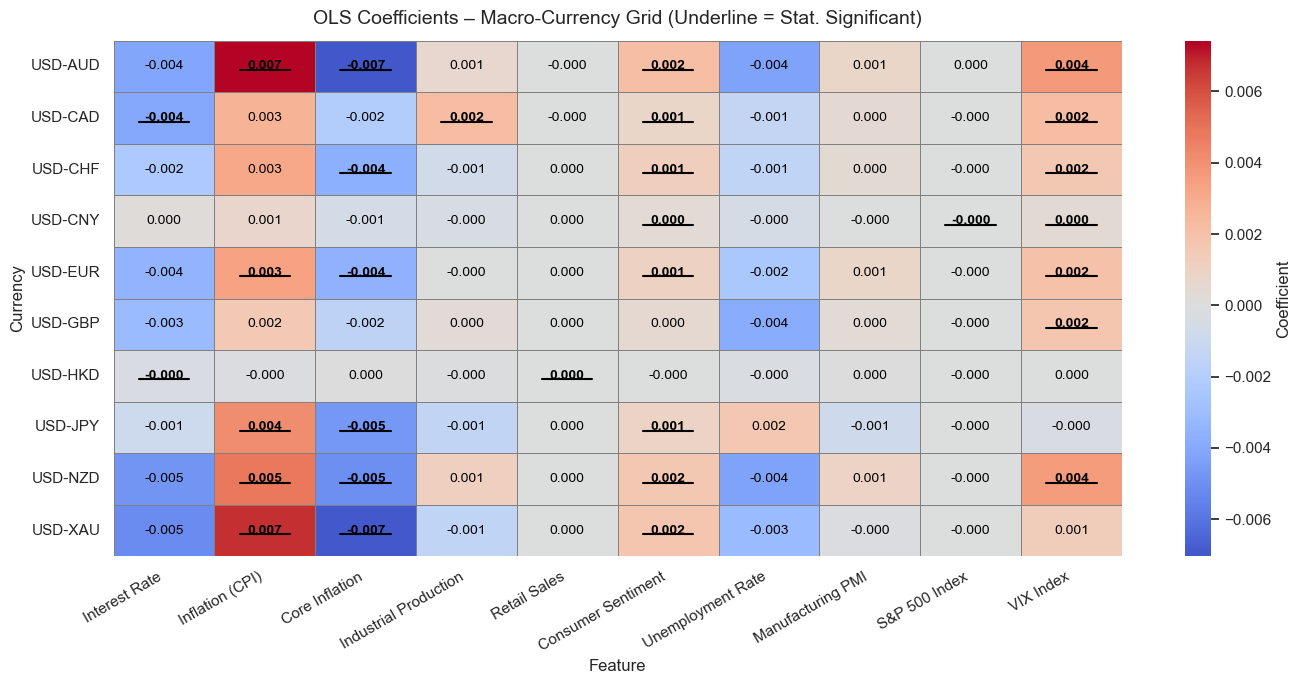

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define base macro features and expected currency list
base_macros = [
    "Interest Rate", "Inflation (CPI)", "Core Inflation", "Industrial Production", "Retail Sales",
    "Consumer Sentiment", "Unemployment Rate", "Manufacturing PMI", "S&P 500 Index", "VIX Index"
]

base_currencies = [
    "USD-AUD", "USD-CAD", "USD-CHF", "USD-CNY", "USD-EUR",
    "USD-GBP", "USD-HKD", "USD-JPY", "USD-NZD", "USD-XAU"
]

# Filter and reindex
filtered_ols = ols_summary[ols_summary["Feature"].isin(base_macros)]
coeffs_pivot = filtered_ols.pivot(index="Currency", columns="Feature", values="Coefficient") \
    .reindex(index=base_currencies, columns=base_macros)
signif_pivot = filtered_ols.pivot(index="Currency", columns="Feature", values="Significant") \
    .reindex(index=base_currencies, columns=base_macros)

# Plot heatmap
plt.figure(figsize=(14, 7))
sns.set(style="white")

ax = sns.heatmap(
    coeffs_pivot,
    annot=False,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    linewidths=0.4,
    linecolor="gray",
    cbar_kws={"label": "Coefficient"}
)

# Annotate and underline significant cells
for y in range(coeffs_pivot.shape[0]):
    for x in range(coeffs_pivot.shape[1]):
        val = coeffs_pivot.iloc[y, x]
        if pd.notna(val):
            sig = signif_pivot.iloc[y, x]
            ax.text(
                x + 0.5, y + 0.5, f"{val:.3f}",
                ha='center', va='center',
                fontsize=10,
                fontweight='bold' if sig == "Yes" else 'normal',
                color='black'
            )
            # Add underline for significant values
            if sig == "Yes":
                ax.plot(
                    [x + 0.25, x + 0.75], [y + 0.57, y + 0.57],
                    color="black", linewidth=1.5, solid_capstyle="round"
                )

plt.title("OLS Coefficients – Macro-Currency Grid (Underline = Stat. Significant)", fontsize=14, pad=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()